- trainデータセットとvalidデータセットを用いて、テキスト分類モデルの実装しなさい(学習が遅い場合、一部のtrainデータセットだけ使っても構いません)
- testデータセットでモデルの精度を検証しなさい

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
# 把三个文件的数据取出来整理成一个数据集
from datasets import Dataset, DatasetDict

train_df = pd.read_csv("./train.csv")
valid_df = pd.read_csv("./valid.csv")
test_df = pd.read_csv("./test.csv")

train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

data_dict = DatasetDict({
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset
})

In [26]:
data_dict

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 20149
    })
    valid: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 1608
    })
    test: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 1781
    })
})

In [27]:
data_dict.set_format(type="pandas")
train_df = data_dict["train"][:]
train_df.head(5)

,sentence,label,user_id,datetime
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,1,1,2012/7/31 23:48
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,0,1,2012/8/2 23:09
2,眠い、眠れない。,1,1,2012/8/8 1:36
3,表情筋が衰えてきてる。まずいな…,1,1,2012/8/11 1:20
4,やばい。おもろいな〜思ってみてみた「シャレードがいっぱい」。よすぎるやん。,0,1,2012/8/16 23:50


In [28]:
data_dict["train"].features

{'sentence': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'user_id': Value(dtype='int64', id=None),
 'datetime': Value(dtype='string', id=None)}

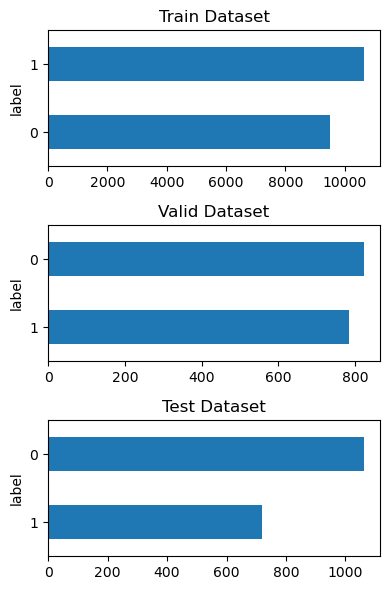

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(4, 6))
data_dict["train"]["label"].value_counts(ascending=True).plot(kind="barh", title="Train Dataset", ax = axes[0])
data_dict["valid"]["label"].value_counts(ascending=True).plot(kind="barh", title="Valid Dataset", ax = axes[1])
data_dict["test"]["label"].value_counts(ascending=True).plot(kind="barh", title="Test Dataset", ax = axes[2])
plt.tight_layout()
plt.show()


<Axes: title={'center': 'text_length'}, xlabel='label'>

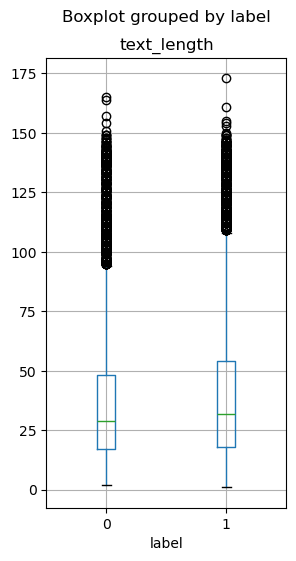

In [32]:
train_df["text_length"]=train_df["sentence"].str.len()
train_df.boxplot(column="text_length", by="label", figsize=(3, 6))

In [ ]:
# 调用模型的分词器进行分词
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-v3')

sample_text_encoded = tokenizer(train_df["sentence"][0])
sample_tokens = tokenizer.convert_ids_to_tokens(sample_text_encoded.input_ids)

print(sample_text_encoded)
print(sample_tokens)


{'input_ids': [2, 478, 7139, 15269, 441, 456, 13123, 21311, 12671, 385, 12651, 7065, 12485, 12488, 13781, 461, 457, 13030, 464, 461, 29, 29, 29, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'ぼ', '##け', '##っと', 'し', 'て', 'たら', 'こんな', '時間', '。', 'チャ', '##リ', 'ある', 'から', '食べ', 'に', 'で', 'たい', 'の', 'に', '.', '.', '.', '[SEP]']


In [10]:
# 在整个数据集上应用分词器
def tokenize(batch):
    return tokenizer(batch["sentence"], padding=True, truncation=True, return_tensors="pt")

data_dict.reset_format()

data_dict = data_dict.map(tokenize, batched=True)

Parameter 'function'=<function tokenize at 0x00000161D25FFCE0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/20149 [00:00<?, ? examples/s]

Map:   0%|          | 0/1608 [00:00<?, ? examples/s]

Map:   0%|          | 0/1781 [00:00<?, ? examples/s]

In [11]:
sample_encoded = data_dict["train"][0]
pd.DataFrame(
    [sample_encoded["input_ids"]
     , sample_encoded["attention_mask"]
     , tokenizer.convert_ids_to_tokens(sample_encoded["input_ids"])],
    ['input_ids', 'attention_mask', "tokens"]
).T

,input_ids,attention_mask,tokens
0,2,1,[CLS]
1,478,1,ぼ
2,7139,1,##け
3,15269,1,##っと
4,441,1,し
...,...,...,...
126,0,0,[PAD]
127,0,0,[PAD]
128,0,0,[PAD]
129,0,0,[PAD]


In [12]:
# 检查cuda是否可用
import torch

if torch.cuda.is_available():
    print("CUDA is available! :D")
    print("CUDA version:", torch.version.cuda)
else:
    print("CUDA is not available. :(")

# 如果安装了cuda还是不可用，可能是cuda和pytorch的版本没有对应上，比如安装了pytorch的cpu版本
# 如果真是版本问题，建议删除当前环境的cuda，pytorch等相关的库，使用conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia 或者 pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118重新安装

CUDA is available! :D
CUDA version: 11.8


In [ ]:
# 定义训练所需参数
from transformers import TrainingArguments

batch_size = 16
logging_steps = len(data_dict["train"]) // batch_size

# 设置模型输出的存储位置
model_name = r"G:\result"


training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

c:\Users\YAN\anaconda3\envs\css\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# 进行设备的设置，如果cuda可用，则使用gpu训练，不可用则使用cpu
# 调用预训练的bert模型
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2

model = (AutoModelForSequenceClassification
    .from_pretrained("cl-tohoku/bert-base-japanese-v3", num_labels=num_labels)
    .to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# 定义模型的性能指标
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [15]:
# 定义训练所需参数
from transformers import TrainingArguments

batch_size = 16
logging_steps = len(data_dict["train"]) // batch_size

# 设置模型输出的存储位置
model_name = r"G:\result"


training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

c:\Users\YAN\anaconda3\envs\css\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
# 测试输出目录是否可用，不可用则生成目录
import os


test_dir = r"G:\result"

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

test_file_path = os.path.join(test_dir, 'test_file.txt')
try:
    with open(test_file_path, 'w') as file:
        file.write('Hello, this is a test file.')
    print("文件写入成功，目录可写。")
except Exception as e:
    print(f"写入文件时发生错误：{e}")


文件写入成功，目录可写。


In [17]:
# 训练模型
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data_dict["train"],
    eval_dataset=data_dict["valid"],
    tokenizer=tokenizer
)
trainer.train() 

  0%|          | 0/2520 [00:00<?, ?it/s]

{'loss': 0.2706, 'grad_norm': 4.4865641593933105, 'learning_rate': 1.0007936507936508e-05, 'epoch': 1.0}


  0%|          | 0/101 [00:00<?, ?it/s]

{'eval_loss': 0.17256227135658264, 'eval_accuracy': 0.9365671641791045, 'eval_f1': 0.936548596659594, 'eval_runtime': 12.2504, 'eval_samples_per_second': 131.261, 'eval_steps_per_second': 8.245, 'epoch': 1.0}
{'loss': 0.135, 'grad_norm': 18.33854866027832, 'learning_rate': 1.5873015873015876e-08, 'epoch': 2.0}


  0%|          | 0/101 [00:00<?, ?it/s]

{'eval_loss': 0.22540374100208282, 'eval_accuracy': 0.9396766169154229, 'eval_f1': 0.939683128388455, 'eval_runtime': 12.4177, 'eval_samples_per_second': 129.493, 'eval_steps_per_second': 8.134, 'epoch': 2.0}
{'train_runtime': 1592.2758, 'train_samples_per_second': 25.308, 'train_steps_per_second': 1.583, 'train_loss': 0.2026427517212661, 'epoch': 2.0}


TrainOutput(global_step=2520, training_loss=0.2026427517212661, metrics={'train_runtime': 1592.2758, 'train_samples_per_second': 25.308, 'train_steps_per_second': 1.583, 'total_flos': 2834618732700480.0, 'train_loss': 0.2026427517212661, 'epoch': 2.0})

In [18]:
preds_output = trainer.predict(data_dict["test"])

  0%|          | 0/112 [00:00<?, ?it/s]

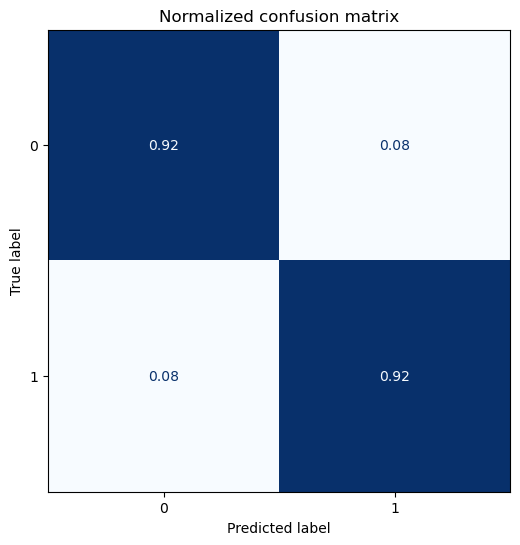

In [ ]:
# 进行预测
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(data_dict["test"]["label"])
labels = ['0', '1']

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)